In [1]:
# !pip install tqdm

In [2]:
import os
import math
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2TokenizerFast
from transformers import GPT2Model
from torch.utils.data import DataLoader, Dataset

d_model = 768
num_head = 8
drop_prob = 0.1
batch_size = 20
max_seq_len = 200
ffn_hidden = 2048
num_layer = 5

#______________________________________________________________________________________________________
# Load Data from CSV
df = pd.read_csv('/content/SPAM text message 20170820 - Data.csv')
df2 = df.tail(1500) # Sample train test split
df = df.head(3500)


def map_value():
    return lambda x: 1 if x == 'spam' else 0


df['Category'] = df['Category'].apply(map_value())
y = df['Category']
text = [_ for _ in df['Message']]

# Import GPT Tokenizer

tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2').to('cuda')
tokenizer.pad_token = tokenizer.eos_token


def get_pos_encoding(seq_len, d_model):
  pos_encoding = np.array(
    [
      [pos / np.power(10000, 2 * (j // 2) / d_model) for j in range(d_model)]
      for pos in range(seq_len)
    ]
  )
  pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
  pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])
  return torch.from_numpy(pos_encoding).float()


# Define a custom Dataset

def tokenize_and_pad(sentences, tokenizer, max_length=50, padding='max_length'):
    print('Processing Tokenization ...')
    tokenized_sentences = tokenizer(sentences, truncation=True, padding=padding, max_length=max_length,
                                    return_tensors='pt')
    input_ids = tokenized_sentences['input_ids']
    attention_mask = tokenized_sentences['attention_mask']

    return input_ids, attention_mask

    # Create dataset and dataLoader


dataset, attention_mask = tokenize_and_pad(text, tokenizer)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

counter = 0
for batch in dataloader:
    counter += 1

all_word_vectors = []
print('Processing Vectorization ...')
with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(dataloader)):
        t1 = time.time()
        batch = batch.to(device='cuda')
        outputs = model(batch)
        word_vectors = outputs.last_hidden_state
        # positional_embeddings = model.wpe(batch)
        all_word_vectors.append(word_vectors + get_pos_encoding(50,768).to('cuda'))
        t2 =time.time()
        # if i % 5 == 0:
          # print(f'Processing Vectorization ... ETC: {round((t2-t1) * (counter-i),1)}sec')

# Concatenate all word vectors from batches
all_word_vectors = torch.cat(all_word_vectors, dim=0).reshape(35,100,50,768)


#____________________________________________________________________________________________________


def scaled_masked_attn(q, k, v, masked=True):
        masked_matrix = torch.triu(
            torch.full((torch.matmul(q, k.transpose(-2, -1)) / (q.shape[-1]) ** 0.5).size(), float('-inf')), diagonal=1).to('cuda')
        scaled = torch.matmul(q, k.transpose(-2, -1)) / (q.shape)[-1] ** 0.5
        if masked == True:
            attention_matrix = F.softmax(scaled + masked_matrix, dim=-1)
        else:
            attention_matrix = F.softmax(scaled, dim=-1)
        values = torch.matmul(attention_matrix, v)
        return attention_matrix, values


class Multi_headed_attension(nn.Module):
    def __init__(self, num_head, d_model):
        super(Multi_headed_attension, self).__init__()
        self.num_head = num_head
        self.d_model = d_model
        self.head_dim = d_model // num_head
        self.qkv_layer = nn.Linear(self.d_model, self.d_model * 3)
        self.linear_layer = nn.Linear(self.d_model, self.d_model)

    def forward(self, x):
        # print('Processing Attention ...')
        # print('Input shape in attension layer is :', x.shape)
        batch_size, seq_len, input_dim = x.size()
        qkv = self.qkv_layer(x)
        qkv = qkv.reshape(batch_size, seq_len, self.num_head, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)
        attention, values = scaled_masked_attn(q=q, v=v, k=k, masked=True)
        values = values.reshape(batch_size, seq_len, self.num_head * self.head_dim)
        out = self.linear_layer(values)
        return out


class FeedForward(nn.Module):
    def __init__(self, shape, hidden_shape, drop_prob=0.1):
        super(FeedForward, self).__init__()
        self.Linear_layer1 = nn.Linear(shape, hidden_shape)
        self.Linear_layer2 = nn.Linear(hidden_shape, shape)
        self.Drop = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = F.relu(self.Linear_layer1(x))
        x = self.Drop(x)
        x = self.Linear_layer2(x)
        return x


class EncoderBlock(nn.Module):
    def __init__(self, d_model, num_head, ffn_hidden, drop_prob=0.1):
        super(EncoderBlock, self).__init__()
        self.attn = Multi_headed_attension(num_head, d_model)
        self.ffn = FeedForward(d_model, ffn_hidden, drop_prob)
        self.LayerNorm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(p=drop_prob)
        self.ffn = FeedForward(d_model, ffn_hidden, drop_prob=drop_prob)

    def forward(self, x):
        residual_x = x
        x = self.attn(x)
        x = self.LayerNorm(self.dropout(x) + residual_x)
        residual_x = x
        x = self.attn(x)
        x = self.LayerNorm(self.dropout(x) + residual_x)
        x = self.ffn(x)
        x = self.dropout(x)
        return self.LayerNorm(residual_x + x)


class Encoder(nn.Module):
    def __init__(self, d_model, num_heads, ffn_hidden, drop_prob=0.1, num_layers=6):
        super(Encoder, self).__init__()
        self.linear_classifier = nn.Linear(50*768, 100)
        self.layers = nn.Sequential(
            *[EncoderBlock(d_model, ffn_hidden, num_heads, drop_prob) for _ in range(num_layers)]
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layers(x)#.mean(dim=0) # donot take mean here, Rather oprate it in a batch with a for loop
        # print('without taking the mean shape is :',x.shape)
        x = x.mean(dim=0) # donot take mean here, Rather oprate it in a batch with a for loop
        # print('without taking the mean shape is :',x.shape)
        x = x.view(-1)
        # print(x.shape)
        x = self.linear_classifier(x)
        x = self.sigmoid((x))
        return x


attention_model = Encoder(d_model, ffn_hidden, num_head, drop_prob, num_layer).to(device='cuda')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Processing Tokenization ...
Processing Vectorization ...


28it [00:03,  8.29it/s]


In [3]:

for batch in range(all_word_vectors.shape[0]):
  out = attention_model(all_word_vectors[batch].reshape(100,50,768))
  print('Input batch dimension',all_word_vectors[batch].shape)
  print(y.shape)
  print('Output batch dimension',out.shape)
  break

Input batch dimension torch.Size([100, 50, 768])
(3500,)
Output batch dimension torch.Size([100])


In [4]:
from torchsummary import summary
summary(attention_model, (50, 768))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 50, 2304]       1,771,776
            Linear-2              [-1, 50, 768]         590,592
Multi_headed_attension-3              [-1, 50, 768]               0
           Dropout-4              [-1, 50, 768]               0
         LayerNorm-5              [-1, 50, 768]           1,536
            Linear-6             [-1, 50, 2304]       1,771,776
            Linear-7              [-1, 50, 768]         590,592
Multi_headed_attension-8              [-1, 50, 768]               0
           Dropout-9              [-1, 50, 768]               0
        LayerNorm-10              [-1, 50, 768]           1,536
           Linear-11             [-1, 50, 2048]       1,574,912
          Dropout-12             [-1, 50, 2048]               0
           Linear-13              [-1, 50, 768]       1,573,632
      FeedForward-14           

In [5]:
y = df['Category']
label = torch.tensor(y).float()#.reshape(-1)

In [6]:
label = label.reshape(35,100).to('cuda')#.transpose(0,1)
label

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 1.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [7]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(attention_model.parameters(), lr=0.0001)

In [8]:
loss_list = []
attention_model.train()
for epoch in tqdm.tqdm(range(250)):
  t1 = time.time()
  batch_loss = []
  for batch in range(all_word_vectors.shape[0]):
    output = attention_model(all_word_vectors[batch].reshape(100,50,768))
    optimizer.zero_grad()
    loss = criterion(output, label[batch].reshape(100))
    loss.backward()
    optimizer.step()
    batch_loss.append(loss.item())
  t2 = time.time()
  print(f'Time remaining for completion is :{round(((t2-t1)*(160-epoch))/60,1)}Min') # Replace this 160 with 250, Later I realized that its a bug, or declaire a generalized variable called Epochs
  loss_list.append(sum(batch_loss)/len(batch_loss))
  print(f'Epoch: {epoch}, Batch: {batch}, Loss: {sum(batch_loss)/len(batch_loss)}')

    # break

  0%|          | 1/250 [00:03<15:40,  3.78s/it]

Time remaining for completion is :10.1Min
Epoch: 0, Batch: 34, Loss: 0.6280032098293304


  1%|          | 2/250 [00:07<15:11,  3.68s/it]

Time remaining for completion is :9.6Min
Epoch: 1, Batch: 34, Loss: 0.4758712002209255


  1%|          | 3/250 [00:10<14:59,  3.64s/it]

Time remaining for completion is :9.5Min
Epoch: 2, Batch: 34, Loss: 0.4336912325450352


  2%|▏         | 4/250 [00:14<14:55,  3.64s/it]

Time remaining for completion is :9.5Min
Epoch: 3, Batch: 34, Loss: 0.4280561455658504


  2%|▏         | 5/250 [00:18<14:49,  3.63s/it]

Time remaining for completion is :9.4Min
Epoch: 4, Batch: 34, Loss: 0.4248727457863944


  2%|▏         | 6/250 [00:21<14:44,  3.63s/it]

Time remaining for completion is :9.3Min
Epoch: 5, Batch: 34, Loss: 0.4224636614322662


  3%|▎         | 7/250 [00:25<14:43,  3.64s/it]

Time remaining for completion is :9.4Min
Epoch: 6, Batch: 34, Loss: 0.4225371326719012


  3%|▎         | 8/250 [00:29<14:40,  3.64s/it]

Time remaining for completion is :9.3Min
Epoch: 7, Batch: 34, Loss: 0.4216245038168771


  4%|▎         | 9/250 [00:32<14:34,  3.63s/it]

Time remaining for completion is :9.2Min
Epoch: 8, Batch: 34, Loss: 0.42430964538029264


  4%|▍         | 10/250 [00:36<14:35,  3.65s/it]

Time remaining for completion is :9.3Min
Epoch: 9, Batch: 34, Loss: 0.4195395486695426


  4%|▍         | 11/250 [00:40<14:30,  3.64s/it]

Time remaining for completion is :9.1Min
Epoch: 10, Batch: 34, Loss: 0.4196870837892805


  5%|▍         | 12/250 [00:43<14:26,  3.64s/it]

Time remaining for completion is :9.0Min
Epoch: 11, Batch: 34, Loss: 0.4183947469506945


  5%|▌         | 13/250 [00:47<14:22,  3.64s/it]

Time remaining for completion is :9.0Min
Epoch: 12, Batch: 34, Loss: 0.421471187046596


  6%|▌         | 14/250 [00:50<14:18,  3.64s/it]

Time remaining for completion is :8.9Min
Epoch: 13, Batch: 34, Loss: 0.4188377048288073


  6%|▌         | 15/250 [00:54<14:14,  3.63s/it]

Time remaining for completion is :8.8Min
Epoch: 14, Batch: 34, Loss: 0.42793525201933724


  6%|▋         | 16/250 [00:58<14:08,  3.63s/it]

Time remaining for completion is :8.7Min
Epoch: 15, Batch: 34, Loss: 0.4193164391177041


  7%|▋         | 17/250 [01:01<14:04,  3.62s/it]

Time remaining for completion is :8.7Min
Epoch: 16, Batch: 34, Loss: 0.4292087972164154


  7%|▋         | 18/250 [01:05<14:02,  3.63s/it]

Time remaining for completion is :8.7Min
Epoch: 17, Batch: 34, Loss: 0.4271614338670458


  8%|▊         | 19/250 [01:09<13:57,  3.63s/it]

Time remaining for completion is :8.6Min
Epoch: 18, Batch: 34, Loss: 0.4222377223627908


  8%|▊         | 20/250 [01:12<13:53,  3.63s/it]

Time remaining for completion is :8.5Min
Epoch: 19, Batch: 34, Loss: 0.4301990602697645


  8%|▊         | 21/250 [01:16<13:49,  3.62s/it]

Time remaining for completion is :8.4Min
Epoch: 20, Batch: 34, Loss: 0.4204366385936737


  9%|▉         | 22/250 [01:19<13:45,  3.62s/it]

Time remaining for completion is :8.4Min
Epoch: 21, Batch: 34, Loss: 0.42194688149860926


  9%|▉         | 23/250 [01:23<13:43,  3.63s/it]

Time remaining for completion is :8.4Min
Epoch: 22, Batch: 34, Loss: 0.4259274056979588


 10%|▉         | 24/250 [01:27<13:38,  3.62s/it]

Time remaining for completion is :8.2Min
Epoch: 23, Batch: 34, Loss: 0.41546477590288433


 10%|█         | 25/250 [01:30<13:34,  3.62s/it]

Time remaining for completion is :8.2Min
Epoch: 24, Batch: 34, Loss: 0.419782977444785


 10%|█         | 26/250 [01:34<13:31,  3.62s/it]

Time remaining for completion is :8.2Min
Epoch: 25, Batch: 34, Loss: 0.4217885502747127


 11%|█         | 27/250 [01:38<13:26,  3.62s/it]

Time remaining for completion is :8.1Min
Epoch: 26, Batch: 34, Loss: 0.41307402764047896


 11%|█         | 28/250 [01:41<13:23,  3.62s/it]

Time remaining for completion is :8.0Min
Epoch: 27, Batch: 34, Loss: 0.4151777275971004


 12%|█▏        | 29/250 [01:45<13:20,  3.62s/it]

Time remaining for completion is :8.0Min
Epoch: 28, Batch: 34, Loss: 0.4186371122087751


 12%|█▏        | 30/250 [01:48<13:16,  3.62s/it]

Time remaining for completion is :7.9Min
Epoch: 29, Batch: 34, Loss: 0.4128831718649183


 12%|█▏        | 31/250 [01:52<13:11,  3.62s/it]

Time remaining for completion is :7.8Min
Epoch: 30, Batch: 34, Loss: 0.4130794014249529


 13%|█▎        | 32/250 [01:56<13:07,  3.61s/it]

Time remaining for completion is :7.8Min
Epoch: 31, Batch: 34, Loss: 0.4161953100136348


 13%|█▎        | 33/250 [01:59<13:06,  3.62s/it]

Time remaining for completion is :7.8Min
Epoch: 32, Batch: 34, Loss: 0.41098562053271703


 14%|█▎        | 34/250 [02:03<13:03,  3.63s/it]

Time remaining for completion is :7.7Min
Epoch: 33, Batch: 34, Loss: 0.40586285846573966


 14%|█▍        | 35/250 [02:07<12:57,  3.62s/it]

Time remaining for completion is :7.5Min
Epoch: 34, Batch: 34, Loss: 0.41084067140306746


 14%|█▍        | 36/250 [02:10<12:57,  3.63s/it]

Time remaining for completion is :7.6Min
Epoch: 35, Batch: 34, Loss: 0.4034859163420541


 15%|█▍        | 37/250 [02:14<12:50,  3.62s/it]

Time remaining for completion is :7.4Min
Epoch: 36, Batch: 34, Loss: 0.3990553021430969


 15%|█▌        | 38/250 [02:17<12:46,  3.61s/it]

Time remaining for completion is :7.4Min
Epoch: 37, Batch: 34, Loss: 0.4036107097353254


 16%|█▌        | 39/250 [02:21<12:44,  3.62s/it]

Time remaining for completion is :7.4Min
Epoch: 38, Batch: 34, Loss: 0.397252357006073


 16%|█▌        | 40/250 [02:25<12:39,  3.62s/it]

Time remaining for completion is :7.3Min
Epoch: 39, Batch: 34, Loss: 0.3918098458221981


 16%|█▋        | 41/250 [02:28<12:36,  3.62s/it]

Time remaining for completion is :7.2Min
Epoch: 40, Batch: 34, Loss: 0.3944382999624525


 17%|█▋        | 42/250 [02:32<12:31,  3.61s/it]

Time remaining for completion is :7.1Min
Epoch: 41, Batch: 34, Loss: 0.38986743177686417


 17%|█▋        | 43/250 [02:35<12:28,  3.61s/it]

Time remaining for completion is :7.1Min
Epoch: 42, Batch: 34, Loss: 0.38382321425846644


 18%|█▊        | 44/250 [02:39<12:26,  3.63s/it]

Time remaining for completion is :7.1Min
Epoch: 43, Batch: 34, Loss: 0.3904739507607051


 18%|█▊        | 45/250 [02:43<12:22,  3.62s/it]

Time remaining for completion is :7.0Min
Epoch: 44, Batch: 34, Loss: 0.38829429575375146


 18%|█▊        | 46/250 [02:46<12:19,  3.62s/it]

Time remaining for completion is :6.9Min
Epoch: 45, Batch: 34, Loss: 0.38586937870298116


 19%|█▉        | 47/250 [02:50<12:16,  3.63s/it]

Time remaining for completion is :6.9Min
Epoch: 46, Batch: 34, Loss: 0.3868618675640651


 19%|█▉        | 48/250 [02:54<12:12,  3.62s/it]

Time remaining for completion is :6.8Min
Epoch: 47, Batch: 34, Loss: 0.3817076061453138


 20%|█▉        | 49/250 [02:57<12:11,  3.64s/it]

Time remaining for completion is :6.8Min
Epoch: 48, Batch: 34, Loss: 0.38065844433648244


 20%|██        | 50/250 [03:01<12:04,  3.62s/it]

Time remaining for completion is :6.6Min
Epoch: 49, Batch: 34, Loss: 0.37848766957010543


 20%|██        | 51/250 [03:05<12:00,  3.62s/it]

Time remaining for completion is :6.6Min
Epoch: 50, Batch: 34, Loss: 0.3736086198261806


 21%|██        | 52/250 [03:08<11:59,  3.63s/it]

Time remaining for completion is :6.7Min
Epoch: 51, Batch: 34, Loss: 0.36359748031411854


 21%|██        | 53/250 [03:12<11:55,  3.63s/it]

Time remaining for completion is :6.5Min
Epoch: 52, Batch: 34, Loss: 0.3632318254028048


 22%|██▏       | 54/250 [03:15<11:50,  3.63s/it]

Time remaining for completion is :6.4Min
Epoch: 53, Batch: 34, Loss: 0.35775614934308186


 22%|██▏       | 55/250 [03:19<11:46,  3.62s/it]

Time remaining for completion is :6.4Min
Epoch: 54, Batch: 34, Loss: 0.3508154034614563


 22%|██▏       | 56/250 [03:23<11:44,  3.63s/it]

Time remaining for completion is :6.4Min
Epoch: 55, Batch: 34, Loss: 0.3491341288600649


 23%|██▎       | 57/250 [03:26<11:40,  3.63s/it]

Time remaining for completion is :6.3Min
Epoch: 56, Batch: 34, Loss: 0.34688541974340165


 23%|██▎       | 58/250 [03:30<11:38,  3.64s/it]

Time remaining for completion is :6.3Min
Epoch: 57, Batch: 34, Loss: 0.34418564779417854


 24%|██▎       | 59/250 [03:34<11:32,  3.63s/it]

Time remaining for completion is :6.1Min
Epoch: 58, Batch: 34, Loss: 0.3377658247947693


 24%|██▍       | 60/250 [03:37<11:29,  3.63s/it]

Time remaining for completion is :6.1Min
Epoch: 59, Batch: 34, Loss: 0.3314480253628322


 24%|██▍       | 61/250 [03:41<11:27,  3.64s/it]

Time remaining for completion is :6.1Min
Epoch: 60, Batch: 34, Loss: 0.32550274814878194


 25%|██▍       | 62/250 [03:44<11:22,  3.63s/it]

Time remaining for completion is :6.0Min
Epoch: 61, Batch: 34, Loss: 0.3196899460894721


 25%|██▌       | 63/250 [03:48<11:19,  3.63s/it]

Time remaining for completion is :5.9Min
Epoch: 62, Batch: 34, Loss: 0.3149602851697377


 26%|██▌       | 64/250 [03:52<11:15,  3.63s/it]

Time remaining for completion is :5.9Min
Epoch: 63, Batch: 34, Loss: 0.31388559980051856


 26%|██▌       | 65/250 [03:55<11:12,  3.63s/it]

Time remaining for completion is :5.8Min
Epoch: 64, Batch: 34, Loss: 0.30715174419539315


 26%|██▋       | 66/250 [03:59<11:06,  3.62s/it]

Time remaining for completion is :5.7Min
Epoch: 65, Batch: 34, Loss: 0.3084816238709858


 27%|██▋       | 67/250 [04:03<11:01,  3.61s/it]

Time remaining for completion is :5.6Min
Epoch: 66, Batch: 34, Loss: 0.3009125990527017


 27%|██▋       | 68/250 [04:06<10:59,  3.62s/it]

Time remaining for completion is :5.6Min
Epoch: 67, Batch: 34, Loss: 0.30896918645926885


 28%|██▊       | 69/250 [04:10<10:54,  3.62s/it]

Time remaining for completion is :5.5Min
Epoch: 68, Batch: 34, Loss: 0.299115954552378


 28%|██▊       | 70/250 [04:13<10:50,  3.62s/it]

Time remaining for completion is :5.5Min
Epoch: 69, Batch: 34, Loss: 0.29781379742281777


 28%|██▊       | 71/250 [04:17<10:51,  3.64s/it]

Time remaining for completion is :5.5Min
Epoch: 70, Batch: 34, Loss: 0.2878717878035137


 29%|██▉       | 72/250 [04:21<10:46,  3.63s/it]

Time remaining for completion is :5.4Min
Epoch: 71, Batch: 34, Loss: 0.27566068768501284


 29%|██▉       | 73/250 [04:24<10:43,  3.63s/it]

Time remaining for completion is :5.3Min
Epoch: 72, Batch: 34, Loss: 0.2648965724876949


 30%|██▉       | 74/250 [04:28<10:38,  3.63s/it]

Time remaining for completion is :5.2Min
Epoch: 73, Batch: 34, Loss: 0.2516305927719389


 30%|███       | 75/250 [04:32<10:34,  3.63s/it]

Time remaining for completion is :5.2Min
Epoch: 74, Batch: 34, Loss: 0.24240814319678716


 30%|███       | 76/250 [04:35<10:30,  3.62s/it]

Time remaining for completion is :5.1Min
Epoch: 75, Batch: 34, Loss: 0.2351265251636505


 31%|███       | 77/250 [04:39<10:27,  3.62s/it]

Time remaining for completion is :5.1Min
Epoch: 76, Batch: 34, Loss: 0.22798067395176205


 31%|███       | 78/250 [04:42<10:24,  3.63s/it]

Time remaining for completion is :5.0Min
Epoch: 77, Batch: 34, Loss: 0.23507215423243386


 32%|███▏      | 79/250 [04:46<10:21,  3.64s/it]

Time remaining for completion is :5.0Min
Epoch: 78, Batch: 34, Loss: 0.24780636302062442


 32%|███▏      | 80/250 [04:50<10:17,  3.63s/it]

Time remaining for completion is :4.9Min
Epoch: 79, Batch: 34, Loss: 0.23999409867184504


 32%|███▏      | 81/250 [04:53<10:14,  3.64s/it]

Time remaining for completion is :4.9Min
Epoch: 80, Batch: 34, Loss: 0.22392677515745163


 33%|███▎      | 82/250 [04:57<10:10,  3.63s/it]

Time remaining for completion is :4.8Min
Epoch: 81, Batch: 34, Loss: 0.21887649872473308


 33%|███▎      | 83/250 [05:01<10:06,  3.63s/it]

Time remaining for completion is :4.7Min
Epoch: 82, Batch: 34, Loss: 0.20823860509055


 34%|███▎      | 84/250 [05:04<10:03,  3.64s/it]

Time remaining for completion is :4.7Min
Epoch: 83, Batch: 34, Loss: 0.20195599155766622


 34%|███▍      | 85/250 [05:08<09:58,  3.63s/it]

Time remaining for completion is :4.6Min
Epoch: 84, Batch: 34, Loss: 0.1958204250250544


 34%|███▍      | 86/250 [05:12<09:55,  3.63s/it]

Time remaining for completion is :4.6Min
Epoch: 85, Batch: 34, Loss: 0.19426325112581252


 35%|███▍      | 87/250 [05:15<09:50,  3.62s/it]

Time remaining for completion is :4.4Min
Epoch: 86, Batch: 34, Loss: 0.18779923702989307


 35%|███▌      | 88/250 [05:19<09:47,  3.62s/it]

Time remaining for completion is :4.4Min
Epoch: 87, Batch: 34, Loss: 0.1904164358973503


 36%|███▌      | 89/250 [05:22<09:43,  3.62s/it]

Time remaining for completion is :4.4Min
Epoch: 88, Batch: 34, Loss: 0.18241750448942184


 36%|███▌      | 90/250 [05:26<09:38,  3.61s/it]

Time remaining for completion is :4.2Min
Epoch: 89, Batch: 34, Loss: 0.17396286023514612


 36%|███▋      | 91/250 [05:30<09:36,  3.62s/it]

Time remaining for completion is :4.3Min
Epoch: 90, Batch: 34, Loss: 0.16557633791651044


 37%|███▋      | 92/250 [05:33<09:31,  3.61s/it]

Time remaining for completion is :4.1Min
Epoch: 91, Batch: 34, Loss: 0.15663077001060757


 37%|███▋      | 93/250 [05:37<09:28,  3.62s/it]

Time remaining for completion is :4.1Min
Epoch: 92, Batch: 34, Loss: 0.1693119701530252


 38%|███▊      | 94/250 [05:41<09:27,  3.64s/it]

Time remaining for completion is :4.1Min
Epoch: 93, Batch: 34, Loss: 0.18114680924585888


 38%|███▊      | 95/250 [05:44<09:26,  3.65s/it]

Time remaining for completion is :4.1Min
Epoch: 94, Batch: 34, Loss: 0.1627972463411944


 38%|███▊      | 96/250 [05:48<09:21,  3.64s/it]

Time remaining for completion is :3.9Min
Epoch: 95, Batch: 34, Loss: 0.14983961528965406


 39%|███▉      | 97/250 [05:51<09:16,  3.64s/it]

Time remaining for completion is :3.9Min
Epoch: 96, Batch: 34, Loss: 0.13647786559803146


 39%|███▉      | 98/250 [05:55<09:11,  3.63s/it]

Time remaining for completion is :3.8Min
Epoch: 97, Batch: 34, Loss: 0.13195999339222908


 40%|███▉      | 99/250 [05:59<09:06,  3.62s/it]

Time remaining for completion is :3.7Min
Epoch: 98, Batch: 34, Loss: 0.12508979556815966


 40%|████      | 100/250 [06:02<09:04,  3.63s/it]

Time remaining for completion is :3.7Min
Epoch: 99, Batch: 34, Loss: 0.12289752566388674


 40%|████      | 101/250 [06:06<08:59,  3.62s/it]

Time remaining for completion is :3.6Min
Epoch: 100, Batch: 34, Loss: 0.11740438863635064


 41%|████      | 102/250 [06:10<08:55,  3.62s/it]

Time remaining for completion is :3.5Min
Epoch: 101, Batch: 34, Loss: 0.10687611198851041


 41%|████      | 103/250 [06:13<08:50,  3.61s/it]

Time remaining for completion is :3.5Min
Epoch: 102, Batch: 34, Loss: 0.09843213504978589


 42%|████▏     | 104/250 [06:17<08:46,  3.61s/it]

Time remaining for completion is :3.4Min
Epoch: 103, Batch: 34, Loss: 0.09574411841375487


 42%|████▏     | 105/250 [06:20<08:42,  3.60s/it]

Time remaining for completion is :3.4Min
Epoch: 104, Batch: 34, Loss: 0.0897738007562501


 42%|████▏     | 106/250 [06:24<08:38,  3.60s/it]

Time remaining for completion is :3.3Min
Epoch: 105, Batch: 34, Loss: 0.08273586199751921


 43%|████▎     | 107/250 [06:28<08:34,  3.60s/it]

Time remaining for completion is :3.2Min
Epoch: 106, Batch: 34, Loss: 0.08204786974404539


 43%|████▎     | 108/250 [06:31<08:30,  3.60s/it]

Time remaining for completion is :3.2Min
Epoch: 107, Batch: 34, Loss: 0.07826224373919623


 44%|████▎     | 109/250 [06:35<08:27,  3.60s/it]

Time remaining for completion is :3.1Min
Epoch: 108, Batch: 34, Loss: 0.07440939343401363


 44%|████▍     | 110/250 [06:38<08:25,  3.61s/it]

Time remaining for completion is :3.1Min
Epoch: 109, Batch: 34, Loss: 0.06851770313722746


 44%|████▍     | 111/250 [06:42<08:20,  3.60s/it]

Time remaining for completion is :3.0Min
Epoch: 110, Batch: 34, Loss: 0.0644121017307043


 45%|████▍     | 112/250 [06:46<08:17,  3.60s/it]

Time remaining for completion is :2.9Min
Epoch: 111, Batch: 34, Loss: 0.060990255113158906


 45%|████▌     | 113/250 [06:49<08:14,  3.61s/it]

Time remaining for completion is :2.9Min
Epoch: 112, Batch: 34, Loss: 0.061835721454450064


 46%|████▌     | 114/250 [06:53<08:10,  3.60s/it]

Time remaining for completion is :2.8Min
Epoch: 113, Batch: 34, Loss: 0.05732193174106734


 46%|████▌     | 115/250 [06:56<08:06,  3.60s/it]

Time remaining for completion is :2.8Min
Epoch: 114, Batch: 34, Loss: 0.05229545044047492


 46%|████▋     | 116/250 [07:00<08:02,  3.60s/it]

Time remaining for completion is :2.7Min
Epoch: 115, Batch: 34, Loss: 0.04863034071666854


 47%|████▋     | 117/250 [07:04<07:59,  3.60s/it]

Time remaining for completion is :2.6Min
Epoch: 116, Batch: 34, Loss: 0.04453533164092473


 47%|████▋     | 118/250 [07:07<07:55,  3.60s/it]

Time remaining for completion is :2.6Min
Epoch: 117, Batch: 34, Loss: 0.042157900705933574


 48%|████▊     | 119/250 [07:11<07:52,  3.61s/it]

Time remaining for completion is :2.5Min
Epoch: 118, Batch: 34, Loss: 0.04046411237546376


 48%|████▊     | 120/250 [07:14<07:49,  3.61s/it]

Time remaining for completion is :2.5Min
Epoch: 119, Batch: 34, Loss: 0.03782117132629667


 48%|████▊     | 121/250 [07:18<07:45,  3.60s/it]

Time remaining for completion is :2.4Min
Epoch: 120, Batch: 34, Loss: 0.03633942827582359


 49%|████▉     | 122/250 [07:22<07:42,  3.62s/it]

Time remaining for completion is :2.4Min
Epoch: 121, Batch: 34, Loss: 0.032575361004897524


 49%|████▉     | 123/250 [07:25<07:39,  3.62s/it]

Time remaining for completion is :2.3Min
Epoch: 122, Batch: 34, Loss: 0.03000607088740383


 50%|████▉     | 124/250 [07:29<07:35,  3.61s/it]

Time remaining for completion is :2.2Min
Epoch: 123, Batch: 34, Loss: 0.028558278935296194


 50%|█████     | 125/250 [07:32<07:31,  3.61s/it]

Time remaining for completion is :2.2Min
Epoch: 124, Batch: 34, Loss: 0.02691516014082091


 50%|█████     | 126/250 [07:36<07:27,  3.61s/it]

Time remaining for completion is :2.1Min
Epoch: 125, Batch: 34, Loss: 0.025174739131970065


 51%|█████     | 127/250 [07:40<07:23,  3.61s/it]

Time remaining for completion is :2.0Min
Epoch: 126, Batch: 34, Loss: 0.023872244996683938


 51%|█████     | 128/250 [07:43<07:19,  3.60s/it]

Time remaining for completion is :2.0Min
Epoch: 127, Batch: 34, Loss: 0.022781452696238245


 52%|█████▏    | 129/250 [07:47<07:17,  3.62s/it]

Time remaining for completion is :1.9Min
Epoch: 128, Batch: 34, Loss: 0.022548574129385608


 52%|█████▏    | 130/250 [07:51<07:13,  3.61s/it]

Time remaining for completion is :1.9Min
Epoch: 129, Batch: 34, Loss: 0.03333429774003369


 52%|█████▏    | 131/250 [07:54<07:08,  3.60s/it]

Time remaining for completion is :1.8Min
Epoch: 130, Batch: 34, Loss: 0.05393639520875045


 53%|█████▎    | 132/250 [07:58<07:05,  3.61s/it]

Time remaining for completion is :1.7Min
Epoch: 131, Batch: 34, Loss: 0.05696154795587063


 53%|█████▎    | 133/250 [08:01<07:01,  3.60s/it]

Time remaining for completion is :1.7Min
Epoch: 132, Batch: 34, Loss: 0.05560461351914065


 54%|█████▎    | 134/250 [08:05<06:57,  3.60s/it]

Time remaining for completion is :1.6Min
Epoch: 133, Batch: 34, Loss: 0.07671807924551623


 54%|█████▍    | 135/250 [08:09<06:54,  3.60s/it]

Time remaining for completion is :1.6Min
Epoch: 134, Batch: 34, Loss: 0.10724214698587145


 54%|█████▍    | 136/250 [08:12<06:50,  3.60s/it]

Time remaining for completion is :1.5Min
Epoch: 135, Batch: 34, Loss: 0.10307965416993414


 55%|█████▍    | 137/250 [08:16<06:47,  3.60s/it]

Time remaining for completion is :1.4Min
Epoch: 136, Batch: 34, Loss: 0.08289103939064911


 55%|█████▌    | 138/250 [08:19<06:43,  3.60s/it]

Time remaining for completion is :1.4Min
Epoch: 137, Batch: 34, Loss: 0.05111895592084953


 56%|█████▌    | 139/250 [08:23<06:40,  3.61s/it]

Time remaining for completion is :1.3Min
Epoch: 138, Batch: 34, Loss: 0.03094806205481291


 56%|█████▌    | 140/250 [08:27<06:36,  3.60s/it]

Time remaining for completion is :1.3Min
Epoch: 139, Batch: 34, Loss: 0.021119691804051398


 56%|█████▋    | 141/250 [08:30<06:32,  3.60s/it]

Time remaining for completion is :1.2Min
Epoch: 140, Batch: 34, Loss: 0.0174549506178924


 57%|█████▋    | 142/250 [08:34<06:30,  3.61s/it]

Time remaining for completion is :1.2Min
Epoch: 141, Batch: 34, Loss: 0.015287150535732508


 57%|█████▋    | 143/250 [08:37<06:25,  3.61s/it]

Time remaining for completion is :1.1Min
Epoch: 142, Batch: 34, Loss: 0.014118781898702894


 58%|█████▊    | 144/250 [08:41<06:21,  3.60s/it]

Time remaining for completion is :1.0Min
Epoch: 143, Batch: 34, Loss: 0.01338212987674134


 58%|█████▊    | 145/250 [08:45<06:18,  3.60s/it]

Time remaining for completion is :1.0Min
Epoch: 144, Batch: 34, Loss: 0.012500116508454085


 58%|█████▊    | 146/250 [08:48<06:17,  3.63s/it]

Time remaining for completion is :0.9Min
Epoch: 145, Batch: 34, Loss: 0.011768231727182865


 59%|█████▉    | 147/250 [08:52<06:13,  3.62s/it]

Time remaining for completion is :0.8Min
Epoch: 146, Batch: 34, Loss: 0.01121264561744673


 59%|█████▉    | 148/250 [08:55<06:09,  3.62s/it]

Time remaining for completion is :0.8Min
Epoch: 147, Batch: 34, Loss: 0.010820365989846842


 60%|█████▉    | 149/250 [08:59<06:06,  3.62s/it]

Time remaining for completion is :0.7Min
Epoch: 148, Batch: 34, Loss: 0.010290123681936944


 60%|██████    | 150/250 [09:03<06:02,  3.62s/it]

Time remaining for completion is :0.7Min
Epoch: 149, Batch: 34, Loss: 0.009805554976420744


 60%|██████    | 151/250 [09:06<05:57,  3.61s/it]

Time remaining for completion is :0.6Min
Epoch: 150, Batch: 34, Loss: 0.009319019271060824


 61%|██████    | 152/250 [09:10<05:54,  3.62s/it]

Time remaining for completion is :0.5Min
Epoch: 151, Batch: 34, Loss: 0.008923558837601117


 61%|██████    | 153/250 [09:14<05:50,  3.62s/it]

Time remaining for completion is :0.5Min
Epoch: 152, Batch: 34, Loss: 0.008468486721228276


 62%|██████▏   | 154/250 [09:17<05:47,  3.62s/it]

Time remaining for completion is :0.4Min
Epoch: 153, Batch: 34, Loss: 0.008175393087523325


 62%|██████▏   | 155/250 [09:21<05:44,  3.63s/it]

Time remaining for completion is :0.4Min
Epoch: 154, Batch: 34, Loss: 0.007821749463411314


 62%|██████▏   | 156/250 [09:24<05:40,  3.62s/it]

Time remaining for completion is :0.3Min
Epoch: 155, Batch: 34, Loss: 0.007483106319393431


 63%|██████▎   | 157/250 [09:28<05:37,  3.62s/it]

Time remaining for completion is :0.2Min
Epoch: 156, Batch: 34, Loss: 0.007379006867163948


 63%|██████▎   | 158/250 [09:32<05:33,  3.63s/it]

Time remaining for completion is :0.2Min
Epoch: 157, Batch: 34, Loss: 0.00707294992171228


 64%|██████▎   | 159/250 [09:35<05:30,  3.63s/it]

Time remaining for completion is :0.1Min
Epoch: 158, Batch: 34, Loss: 0.006862645210432155


 64%|██████▍   | 160/250 [09:39<05:26,  3.63s/it]

Time remaining for completion is :0.1Min
Epoch: 159, Batch: 34, Loss: 0.0067363792697766


 64%|██████▍   | 161/250 [09:43<05:23,  3.64s/it]

Time remaining for completion is :0.0Min
Epoch: 160, Batch: 34, Loss: 0.006267430087817567


 65%|██████▍   | 162/250 [09:46<05:20,  3.64s/it]

Time remaining for completion is :-0.1Min
Epoch: 161, Batch: 34, Loss: 0.00601542246794062


 65%|██████▌   | 163/250 [09:50<05:15,  3.63s/it]

Time remaining for completion is :-0.1Min
Epoch: 162, Batch: 34, Loss: 0.005771133915654251


 66%|██████▌   | 164/250 [09:54<05:12,  3.64s/it]

Time remaining for completion is :-0.2Min
Epoch: 163, Batch: 34, Loss: 0.005514361370088799


 66%|██████▌   | 165/250 [09:57<05:08,  3.63s/it]

Time remaining for completion is :-0.2Min
Epoch: 164, Batch: 34, Loss: 0.005572940099851362


 66%|██████▋   | 166/250 [10:01<05:04,  3.63s/it]

Time remaining for completion is :-0.3Min
Epoch: 165, Batch: 34, Loss: 0.005481673856931073


 67%|██████▋   | 167/250 [10:04<05:00,  3.62s/it]

Time remaining for completion is :-0.4Min
Epoch: 166, Batch: 34, Loss: 0.0051476125339312215


 67%|██████▋   | 168/250 [10:08<04:58,  3.64s/it]

Time remaining for completion is :-0.4Min
Epoch: 167, Batch: 34, Loss: 0.004925674539325493


 68%|██████▊   | 169/250 [10:12<04:53,  3.63s/it]

Time remaining for completion is :-0.5Min
Epoch: 168, Batch: 34, Loss: 0.004714031570724079


 68%|██████▊   | 170/250 [10:15<04:49,  3.62s/it]

Time remaining for completion is :-0.5Min
Epoch: 169, Batch: 34, Loss: 0.004569860823851611


 68%|██████▊   | 171/250 [10:19<04:46,  3.62s/it]

Time remaining for completion is :-0.6Min
Epoch: 170, Batch: 34, Loss: 0.004437824325369937


 69%|██████▉   | 172/250 [10:23<04:42,  3.62s/it]

Time remaining for completion is :-0.7Min
Epoch: 171, Batch: 34, Loss: 0.004275670205242932


 69%|██████▉   | 173/250 [10:26<04:38,  3.62s/it]

Time remaining for completion is :-0.7Min
Epoch: 172, Batch: 34, Loss: 0.004108466307765671


 70%|██████▉   | 174/250 [10:30<04:35,  3.63s/it]

Time remaining for completion is :-0.8Min
Epoch: 173, Batch: 34, Loss: 0.0039615020688091


 70%|███████   | 175/250 [10:33<04:32,  3.63s/it]

Time remaining for completion is :-0.8Min
Epoch: 174, Batch: 34, Loss: 0.0038325042630146656


 70%|███████   | 176/250 [10:37<04:29,  3.64s/it]

Time remaining for completion is :-0.9Min
Epoch: 175, Batch: 34, Loss: 0.00365253073895084


 71%|███████   | 177/250 [10:41<04:25,  3.64s/it]

Time remaining for completion is :-1.0Min
Epoch: 176, Batch: 34, Loss: 0.003552877124665039


 71%|███████   | 178/250 [10:44<04:22,  3.65s/it]

Time remaining for completion is :-1.0Min
Epoch: 177, Batch: 34, Loss: 0.003680177595067237


 72%|███████▏  | 179/250 [10:48<04:19,  3.65s/it]

Time remaining for completion is :-1.1Min
Epoch: 178, Batch: 34, Loss: 0.003452074381389788


 72%|███████▏  | 180/250 [10:52<04:15,  3.65s/it]

Time remaining for completion is :-1.2Min
Epoch: 179, Batch: 34, Loss: 0.0033512974424021584


 72%|███████▏  | 181/250 [10:55<04:11,  3.64s/it]

Time remaining for completion is :-1.2Min
Epoch: 180, Batch: 34, Loss: 0.003156869828567973


 73%|███████▎  | 182/250 [10:59<04:06,  3.63s/it]

Time remaining for completion is :-1.3Min
Epoch: 181, Batch: 34, Loss: 0.0030307616905442306


 73%|███████▎  | 183/250 [11:03<04:03,  3.63s/it]

Time remaining for completion is :-1.3Min
Epoch: 182, Batch: 34, Loss: 0.003015496362266796


 74%|███████▎  | 184/250 [11:06<03:59,  3.63s/it]

Time remaining for completion is :-1.4Min
Epoch: 183, Batch: 34, Loss: 0.0034293339221871323


 74%|███████▍  | 185/250 [11:10<03:55,  3.63s/it]

Time remaining for completion is :-1.4Min
Epoch: 184, Batch: 34, Loss: 0.0031023691707689847


 74%|███████▍  | 186/250 [11:13<03:52,  3.63s/it]

Time remaining for completion is :-1.5Min
Epoch: 185, Batch: 34, Loss: 0.0027446398212175285


 75%|███████▍  | 187/250 [11:17<03:49,  3.64s/it]

Time remaining for completion is :-1.6Min
Epoch: 186, Batch: 34, Loss: 0.002573116737351354


 75%|███████▌  | 188/250 [11:21<03:44,  3.63s/it]

Time remaining for completion is :-1.6Min
Epoch: 187, Batch: 34, Loss: 0.00245610937210066


 76%|███████▌  | 189/250 [11:24<03:40,  3.62s/it]

Time remaining for completion is :-1.7Min
Epoch: 188, Batch: 34, Loss: 0.0024205805816953736


 76%|███████▌  | 190/250 [11:28<03:37,  3.62s/it]

Time remaining for completion is :-1.7Min
Epoch: 189, Batch: 34, Loss: 0.0023078625423035453


 76%|███████▋  | 191/250 [11:32<03:33,  3.62s/it]

Time remaining for completion is :-1.8Min
Epoch: 190, Batch: 34, Loss: 0.0022710566192732325


 77%|███████▋  | 192/250 [11:35<03:30,  3.62s/it]

Time remaining for completion is :-1.9Min
Epoch: 191, Batch: 34, Loss: 0.0022580967101800656


 77%|███████▋  | 193/250 [11:39<03:26,  3.62s/it]

Time remaining for completion is :-1.9Min
Epoch: 192, Batch: 34, Loss: 0.002148457175852465


 78%|███████▊  | 194/250 [11:42<03:22,  3.62s/it]

Time remaining for completion is :-2.0Min
Epoch: 193, Batch: 34, Loss: 0.0020199110249190457


 78%|███████▊  | 195/250 [11:46<03:18,  3.61s/it]

Time remaining for completion is :-2.0Min
Epoch: 194, Batch: 34, Loss: 0.0018808035396172531


 78%|███████▊  | 196/250 [11:50<03:15,  3.62s/it]

Time remaining for completion is :-2.1Min
Epoch: 195, Batch: 34, Loss: 0.001778684461688889


 79%|███████▉  | 197/250 [11:53<03:12,  3.63s/it]

Time remaining for completion is :-2.2Min
Epoch: 196, Batch: 34, Loss: 0.0017228033925805774


 79%|███████▉  | 198/250 [11:57<03:08,  3.62s/it]

Time remaining for completion is :-2.2Min
Epoch: 197, Batch: 34, Loss: 0.0016759108153304883


 80%|███████▉  | 199/250 [12:01<03:04,  3.62s/it]

Time remaining for completion is :-2.3Min
Epoch: 198, Batch: 34, Loss: 0.001592001031219427


 80%|████████  | 200/250 [12:04<03:01,  3.62s/it]

Time remaining for completion is :-2.4Min
Epoch: 199, Batch: 34, Loss: 0.0015557278113971864


 80%|████████  | 201/250 [12:08<02:57,  3.62s/it]

Time remaining for completion is :-2.4Min
Epoch: 200, Batch: 34, Loss: 0.0015188955668626086


 81%|████████  | 202/250 [12:11<02:53,  3.61s/it]

Time remaining for completion is :-2.5Min
Epoch: 201, Batch: 34, Loss: 0.0014362719375640154


 81%|████████  | 203/250 [12:15<02:50,  3.62s/it]

Time remaining for completion is :-2.5Min
Epoch: 202, Batch: 34, Loss: 0.001397446812396603


 82%|████████▏ | 204/250 [12:19<02:46,  3.61s/it]

Time remaining for completion is :-2.6Min
Epoch: 203, Batch: 34, Loss: 0.0013478078829523709


 82%|████████▏ | 205/250 [12:22<02:42,  3.61s/it]

Time remaining for completion is :-2.7Min
Epoch: 204, Batch: 34, Loss: 0.0013422725306424712


 82%|████████▏ | 206/250 [12:26<02:39,  3.62s/it]

Time remaining for completion is :-2.7Min
Epoch: 205, Batch: 34, Loss: 0.0014890114677005581


 83%|████████▎ | 207/250 [12:29<02:35,  3.62s/it]

Time remaining for completion is :-2.8Min
Epoch: 206, Batch: 34, Loss: 0.0012836045768511082


 83%|████████▎ | 208/250 [12:33<02:32,  3.63s/it]

Time remaining for completion is :-2.8Min
Epoch: 207, Batch: 34, Loss: 0.0012077954032325318


 84%|████████▎ | 209/250 [12:37<02:28,  3.63s/it]

Time remaining for completion is :-2.9Min
Epoch: 208, Batch: 34, Loss: 0.0011530538189357944


 84%|████████▍ | 210/250 [12:40<02:25,  3.63s/it]

Time remaining for completion is :-3.0Min
Epoch: 209, Batch: 34, Loss: 0.0011127821252947406


 84%|████████▍ | 211/250 [12:44<02:21,  3.63s/it]

Time remaining for completion is :-3.0Min
Epoch: 210, Batch: 34, Loss: 0.0010842859595348792


 85%|████████▍ | 212/250 [12:48<02:17,  3.62s/it]

Time remaining for completion is :-3.1Min
Epoch: 211, Batch: 34, Loss: 0.0010557721601799131


 85%|████████▌ | 213/250 [12:51<02:14,  3.63s/it]

Time remaining for completion is :-3.2Min
Epoch: 212, Batch: 34, Loss: 0.0010086881462484597


 86%|████████▌ | 214/250 [12:55<02:10,  3.64s/it]

Time remaining for completion is :-3.2Min
Epoch: 213, Batch: 34, Loss: 0.0009906884831642467


 86%|████████▌ | 215/250 [12:58<02:06,  3.63s/it]

Time remaining for completion is :-3.2Min
Epoch: 214, Batch: 34, Loss: 0.0009376949422793197


 86%|████████▋ | 216/250 [13:02<02:03,  3.64s/it]

Time remaining for completion is :-3.4Min
Epoch: 215, Batch: 34, Loss: 0.0009026805338050638


 87%|████████▋ | 217/250 [13:06<01:59,  3.63s/it]

Time remaining for completion is :-3.4Min
Epoch: 216, Batch: 34, Loss: 0.0008666229176534605


 87%|████████▋ | 218/250 [13:09<01:56,  3.63s/it]

Time remaining for completion is :-3.5Min
Epoch: 217, Batch: 34, Loss: 0.0008360761899634131


 88%|████████▊ | 219/250 [13:13<01:52,  3.63s/it]

Time remaining for completion is :-3.5Min
Epoch: 218, Batch: 34, Loss: 0.0008271506530166204


 88%|████████▊ | 220/250 [13:17<01:48,  3.63s/it]

Time remaining for completion is :-3.6Min
Epoch: 219, Batch: 34, Loss: 0.0007959263665335519


 88%|████████▊ | 221/250 [13:20<01:45,  3.63s/it]

Time remaining for completion is :-3.6Min
Epoch: 220, Batch: 34, Loss: 0.0007710777505833123


 89%|████████▉ | 222/250 [13:24<01:41,  3.63s/it]

Time remaining for completion is :-3.7Min
Epoch: 221, Batch: 34, Loss: 0.0007439722082511123


 89%|████████▉ | 223/250 [13:28<01:37,  3.62s/it]

Time remaining for completion is :-3.7Min
Epoch: 222, Batch: 34, Loss: 0.0007023707057149815


 90%|████████▉ | 224/250 [13:31<01:34,  3.63s/it]

Time remaining for completion is :-3.8Min
Epoch: 223, Batch: 34, Loss: 0.00068575250916183


 90%|█████████ | 225/250 [13:35<01:30,  3.62s/it]

Time remaining for completion is :-3.8Min
Epoch: 224, Batch: 34, Loss: 0.0006717913858925125


 90%|█████████ | 226/250 [13:38<01:26,  3.62s/it]

Time remaining for completion is :-3.9Min
Epoch: 225, Batch: 34, Loss: 0.0006604078982491047


 91%|█████████ | 227/250 [13:42<01:23,  3.62s/it]

Time remaining for completion is :-4.0Min
Epoch: 226, Batch: 34, Loss: 0.0007919440095845078


 91%|█████████ | 228/250 [13:46<01:19,  3.61s/it]

Time remaining for completion is :-4.0Min
Epoch: 227, Batch: 34, Loss: 0.0007243014780604946


 92%|█████████▏| 229/250 [13:49<01:15,  3.61s/it]

Time remaining for completion is :-4.1Min
Epoch: 228, Batch: 34, Loss: 0.0006480147421825677


 92%|█████████▏| 230/250 [13:53<01:12,  3.63s/it]

Time remaining for completion is :-4.2Min
Epoch: 229, Batch: 34, Loss: 0.0006432350932820035


 92%|█████████▏| 231/250 [13:56<01:08,  3.63s/it]

Time remaining for completion is :-4.2Min
Epoch: 230, Batch: 34, Loss: 0.000650549290003255


 93%|█████████▎| 232/250 [14:00<01:05,  3.64s/it]

Time remaining for completion is :-4.3Min
Epoch: 231, Batch: 34, Loss: 0.0005776487315805363


 93%|█████████▎| 233/250 [14:04<01:01,  3.63s/it]

Time remaining for completion is :-4.3Min
Epoch: 232, Batch: 34, Loss: 0.0005553548831293094


 94%|█████████▎| 234/250 [14:07<00:57,  3.62s/it]

Time remaining for completion is :-4.4Min
Epoch: 233, Batch: 34, Loss: 0.0005397069184774799


 94%|█████████▍| 235/250 [14:11<00:54,  3.63s/it]

Time remaining for completion is :-4.5Min
Epoch: 234, Batch: 34, Loss: 0.0005249294369215412


 94%|█████████▍| 236/250 [14:15<00:50,  3.62s/it]

Time remaining for completion is :-4.5Min
Epoch: 235, Batch: 34, Loss: 0.0004991445424301284


 95%|█████████▍| 237/250 [14:18<00:47,  3.62s/it]

Time remaining for completion is :-4.6Min
Epoch: 236, Batch: 34, Loss: 0.0004856150273034083


 95%|█████████▌| 238/250 [14:22<00:43,  3.63s/it]

Time remaining for completion is :-4.7Min
Epoch: 237, Batch: 34, Loss: 0.00046344163253836867


 96%|█████████▌| 239/250 [14:26<00:40,  3.64s/it]

Time remaining for completion is :-4.8Min
Epoch: 238, Batch: 34, Loss: 0.00044458735376662974


 96%|█████████▌| 240/250 [14:29<00:36,  3.65s/it]

Time remaining for completion is :-4.8Min
Epoch: 239, Batch: 34, Loss: 0.0004391266336564773


 96%|█████████▋| 241/250 [14:33<00:32,  3.66s/it]

Time remaining for completion is :-4.9Min
Epoch: 240, Batch: 34, Loss: 0.0004461926848827196


 97%|█████████▋| 242/250 [14:37<00:29,  3.66s/it]

Time remaining for completion is :-4.9Min
Epoch: 241, Batch: 34, Loss: 0.0004352814954472706


 97%|█████████▋| 243/250 [14:40<00:25,  3.66s/it]

Time remaining for completion is :-5.0Min
Epoch: 242, Batch: 34, Loss: 0.0004309655566300665


 98%|█████████▊| 244/250 [14:44<00:21,  3.66s/it]

Time remaining for completion is :-5.1Min
Epoch: 243, Batch: 34, Loss: 0.00039661755477676965


 98%|█████████▊| 245/250 [14:48<00:18,  3.66s/it]

Time remaining for completion is :-5.1Min
Epoch: 244, Batch: 34, Loss: 0.0003806030726991594


 98%|█████████▊| 246/250 [14:51<00:14,  3.67s/it]

Time remaining for completion is :-5.2Min
Epoch: 245, Batch: 34, Loss: 0.000379520737832146


 99%|█████████▉| 247/250 [14:55<00:11,  3.69s/it]

Time remaining for completion is :-5.4Min
Epoch: 246, Batch: 34, Loss: 0.0003651074429009376


 99%|█████████▉| 248/250 [14:59<00:07,  3.68s/it]

Time remaining for completion is :-5.3Min
Epoch: 247, Batch: 34, Loss: 0.0003493557862904189


100%|█████████▉| 249/250 [15:02<00:03,  3.67s/it]

Time remaining for completion is :-5.3Min
Epoch: 248, Batch: 34, Loss: 0.00033901605804982995


100%|██████████| 250/250 [15:06<00:00,  3.63s/it]

Time remaining for completion is :-5.4Min
Epoch: 249, Batch: 34, Loss: 0.00033062555428062164


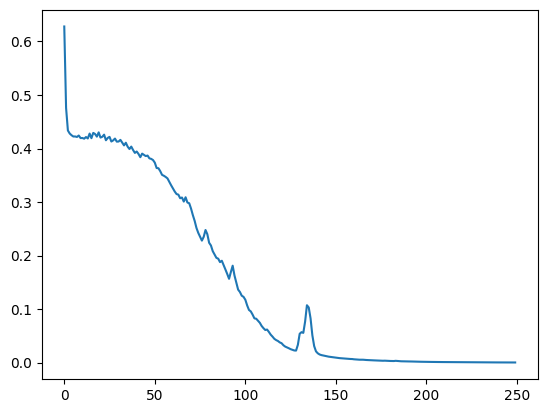

In [11]:
import matplotlib.pyplot as plt
x = np.arange(0, 250)
plt.plot(x, loss_list)
plt.show()

In [12]:
attention_model.eval()
with torch.no_grad():
  output = attention_model(all_word_vectors[0].reshape(100,50,768))
  print(output)
threshold = 0.5
binary_output = (output >= threshold).int()

tensor([1.3575e-04, 2.0071e-06, 9.9915e-01, 1.0797e-05, 3.5549e-05, 9.9958e-01,
        1.1690e-08, 1.9349e-06, 9.9922e-01, 9.9976e-01, 2.8705e-04, 9.9911e-01,
        9.9917e-01, 1.5736e-05, 2.1125e-04, 9.9866e-01, 1.4553e-04, 5.5679e-10,
        3.6749e-04, 9.9876e-01, 5.2039e-04, 6.4692e-05, 3.2575e-08, 3.6077e-06,
        1.3359e-04, 1.6320e-06, 2.8985e-04, 1.4873e-07, 3.1582e-06, 1.7519e-04,
        4.9754e-05, 2.1957e-07, 1.5248e-05, 1.6527e-04, 9.9871e-01, 3.1162e-07,
        3.7876e-06, 7.7589e-05, 9.5963e-09, 6.6928e-07, 3.3257e-07, 1.0517e-04,
        9.9958e-01, 1.7718e-04, 8.8063e-06, 3.9735e-05, 8.0302e-05, 2.4140e-06,
        1.1515e-05, 4.5049e-06, 2.7165e-06, 2.5295e-08, 1.3794e-05, 1.1881e-06,
        9.9925e-01, 5.5542e-07, 9.9944e-01, 8.6684e-06, 2.1411e-05, 2.2890e-04,
        4.1795e-05, 5.5264e-05, 8.8727e-07, 1.3718e-06, 1.3322e-03, 9.9871e-01,
        2.5529e-08, 9.9997e-01, 9.9914e-01, 1.3978e-07, 6.3334e-04, 1.4678e-07,
        1.9883e-07, 5.7004e-08, 9.6272e-

In [13]:
binary_output

tensor([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0], device='cuda:0', dtype=torch.int32)

In [14]:
oroginal_label = torch.tensor(df['Category'].head(100)).to('cuda')
print(oroginal_label == binary_output)


tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True], device='cuda:0')


In [15]:
df2['Category'] = df2['Category'].apply(map_value())
y = df2['Category']
text2 = [_ for _ in df2['Message']]

# Import GPT Tokenizer

tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2').to('cuda')
tokenizer.pad_token = tokenizer.eos_token


def get_pos_encoding(seq_len, d_model):
  pos_encoding = np.array(
    [
      [pos / np.power(10000, 2 * (j // 2) / d_model) for j in range(d_model)]
      for pos in range(seq_len)
    ]
  )
  pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
  pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])
  return torch.from_numpy(pos_encoding).float()


# Define a custom Dataset

def tokenize_and_pad(sentences, tokenizer, max_length=50, padding='max_length'):
    print('Processing Tokenization ...')
    tokenized_sentences = tokenizer(sentences, truncation=True, padding=padding, max_length=max_length,
                                    return_tensors='pt')
    input_ids = tokenized_sentences['input_ids']
    attention_mask = tokenized_sentences['attention_mask']

    return input_ids, attention_mask

    # Create dataset and dataLoader


dataset, attention_mask = tokenize_and_pad(text2, tokenizer)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

counter = 0
for batch in dataloader:
    counter += 1

all_word_vectors = []
print('Processing Vectorization ...')
with torch.no_grad():
    for i, batch in enumerate(dataloader):
        t1 = time.time()
        batch = batch.to(device='cuda')
        outputs = model(batch)
        word_vectors = outputs.last_hidden_state
        # positional_embeddings = model.wpe(batch)
        all_word_vectors.append(word_vectors + get_pos_encoding(50,768).to('cuda'))
        t2 =time.time()
        if i % 5 == 0:
          print(f'Processing Vectorization ... ETC: {round((t2-t1) * (counter-i),1)}sec')

# Concatenate all word vectors from batches
all_word_vectors = torch.cat(all_word_vectors, dim=0).reshape(15,100,50,768)

Processing Tokenization ...
Processing Vectorization ...
Processing Vectorization ... ETC: 1.1sec
Processing Vectorization ... ETC: 0.5sec
Processing Vectorization ... ETC: 0.2sec


In [16]:
all_word_vectors.shape

torch.Size([15, 100, 50, 768])

In [17]:
attention_model.eval()
output_list = []
with torch.no_grad():
  for batch in range(all_word_vectors.shape[0]):
    output = attention_model(all_word_vectors[batch].reshape(100,50,768))
    output_list.append(output.cpu().numpy())

threshold = 0.5
binary_output = (output >= threshold).int()

In [18]:
y = df2['Category']
label = torch.tensor(y.to_numpy()).float()
label = label.reshape(15,100).to('cuda')
label.shape

torch.Size([15, 100])

In [19]:
eval_result = list((label == binary_output).flatten().cpu().numpy())
Performance = (sum(eval_result)/len(eval_result))*100
print(f'Performance: {Performance}%')

Performance: 84.33333333333334%
